In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
plt.rcParams["font.family"] = "serif"

from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras.models import model_from_json

Using TensorFlow backend.


In [2]:
#pos = np.random.normal(0,1,3000000)
#neg = np.random.normal(0,0.5,1000000)
#posW = np.ones(len(pos))
#negW = -np.ones(len(neg))
#tot = np.concatenate([pos,neg])
#totW = np.concatenate([posW,negW])

In [3]:
#model = Sequential()
#model.add(Dense(128, input_dim=1, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(128, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [4]:
#x_vals = np.concatenate([tot,tot])
#y_vals = np.concatenate([np.ones(len(tot)),np.zeros(len(tot))])
#w_vals = np.concatenate([totW,np.ones(len(tot))])
#X_train, X_val, Y_train, Y_val, W_train, W_val = train_test_split(x_vals, y_vals, w_vals, test_size=0.5)

In [5]:
#np.save("X_train",X_train)
#np.save("X_val",X_val)
#np.save("Y_train",Y_train)
#np.save("Y_val",Y_val)
#np.save("W_train",W_train)
#np.save("W_val",W_val)

In [6]:
X_train = np.load("X_train.npy")
X_val = np.load("X_val.npy")
Y_train = np.load("Y_train.npy")
Y_val = np.load("Y_val.npy")
W_train = np.load("W_train.npy")
W_val = np.load("W_val.npy")

In [7]:
#myhistory = model.fit(x_vals, y_vals, sample_weight=w_vals,epochs=10,validation_data=(X_val, Y_val, W_val),batch_size=int(0.01*len(X_train)),verbose=1)

In [8]:
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights("model.h5")

In [9]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("model.h5")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
#plt.plot(myhistory.history['val_loss'],label="val loss")
#plt.plot(myhistory.history['loss'],label="loss")
#plt.legend(frameon=False)

In [11]:
#plt.plot(myhistory.history['val_accuracy'],label="val accuracy")
#plt.plot(myhistory.history['accuracy'],label="accuracy")
#plt.legend(frameon=False)

In [12]:
predicted_w = model.predict(X_val)

In [13]:
myw = predicted_w / (1.-predicted_w)

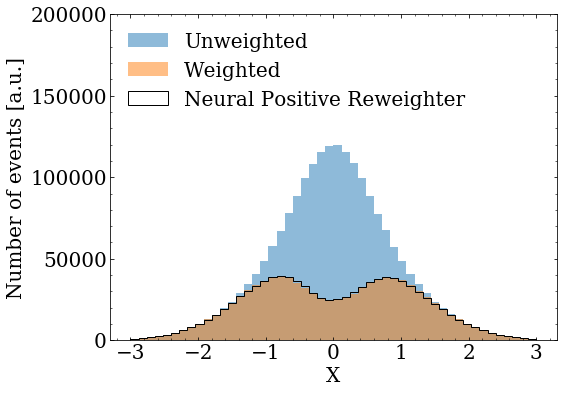

In [14]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(X_val[Y_val==0],bins=np.linspace(-3,3,51),alpha=0.5,label="Unweighted")
_,_,_=plt.hist(X_val[Y_val==1],weights=W_val[Y_val==1],bins=np.linspace(-3,3,51),alpha=0.5,label="Weighted")
_,_,_=plt.hist(X_val[Y_val==0],weights=myw[Y_val==0],bins=np.linspace(-3,3,51),label="Neural Positive Reweighter",histtype="step",color="black")
plt.legend(frameon=False,fontsize=20,loc="upper left")
plt.ylim([0,200000])
plt.ylabel("Number of events [a.u.]",fontsize=20)
plt.xlabel("X",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.savefig("gauss.pdf",bbox_inches='tight')

In [15]:
from scipy.stats import norm
def analytic_weight(x):
    gaus1 = norm.pdf(x)*3
    gaus2 = norm.pdf(x,scale=0.5)
    return (gaus1-gaus2)/(gaus1+gaus2)

In [16]:
analytic_weights = analytic_weight(X_val)

## Now for reducing the stats.

In [17]:
keepprobs = myw[Y_val==1]**2
for i in range(len(keepprobs)):
    if (keepprobs[i] > 1.):
        keepprobs[i]=1.
        pass
    pass
keep = np.random.binomial(1,keepprobs)
initweights = myw[Y_val==1]
initxvals = X_val[Y_val==1]
neweights = []
newxvals = []
for i in range(len(keep)):
    if (keep[i]==1):
        neweights+=[1./(0.00001+initweights[i][0])]
        newxvals+=[initxvals[i]]
    pass

In [18]:
neweights = np.array(neweights)

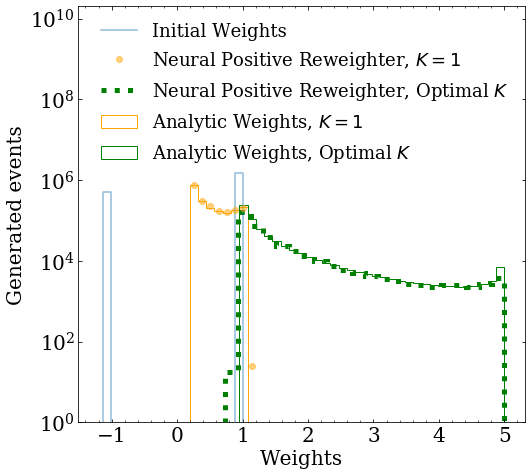

In [19]:
fig = plt.figure(figsize=(8, 7.65))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

myn0,bmjj=np.histogram(W_val[Y_val==1],bins=np.linspace(-1.2,5,50))
plt.step(0.5*(bmjj[1:]+bmjj[:-1]),myn0,label="Initial Weights",alpha=0.5)

plt.hist(analytic_weights[Y_val==0],label="Analytic Weights, $K=1$",color="orange",histtype="step",bins=np.linspace(-1.2,5,50),linewidth=1)
plt.hist(1./analytic_weights[Y_val==0],weights=analytic_weights[Y_val==0]**2,label="Analytic Weights, Optimal $K$",color="green",histtype="step",bins=np.linspace(-1.2,5,50))

myn,_=np.histogram(myw[Y_val==0],bins=np.linspace(-1.2,5,50))
myn2,_=np.histogram(-1000*neweights,bins=np.linspace(-1.2,5.,50))
myn2+=[0]
plt.plot(0.5*(bmjj[1:]+bmjj[:-1]),myn,label=r"Neural Positive Reweighter, $K=1$",color='orange',alpha=0.5,marker='o',ls="")
plt.step(0.5*(bmjj[1:]+bmjj[:-1])+0.5*6/50,myn2,label=r"Neural Positive Reweighter, Optimal $K$",color="green",ls=":",linewidth=5)

plt.legend(frameon=False,fontsize=18)

#Binning artifacts in the last bin.
_,_,_=plt.hist(neweights,bins=np.linspace(-1.2,5.,33),weights=3/5.*np.ones(len(neweights)),color="green",ls=":",linewidth=5,histtype="step")

plt.xlabel(r"Weights",fontsize=20)
plt.ylim([1,2e10])
plt.yscale("log")
plt.ylabel(r"Generated events",fontsize=20)
#plt.locator_params(axis='y', nbins=6)
plt.savefig("wgauss.pdf",bbox_inches='tight')

In [20]:
Bins_val = np.array([np.digitize(x,np.linspace(-3,3,51)) for x in X_val])

In [21]:
Bins_newval = np.array([np.digitize(x,np.linspace(-3,3,51)) for x in newxvals])

In [22]:
W2_original = [sum(W_val[(Y_val==1) & (Bins_val==i)]**2) for i in range(51)]
W2_new = [sum(myw[(Y_val==0) & (Bins_val==i)]**2) for i in range(51)]
W2_sampled = [sum(neweights[Bins_newval==i]**2) for i in range(51)]

L2_original = [len(W_val[(Y_val==1) & (Bins_val==i)]**2) for i in range(51)]
L2_new = [len(myw[(Y_val==0) & (Bins_val==i)]**2) for i in range(51)]
L2_sampled = [len(neweights[Bins_newval==i]**2) for i in range(51)]

In [23]:
W2_original = np.array(W2_original)
W2_new = np.array(W2_new)
W2_sampled = np.array(W2_sampled)

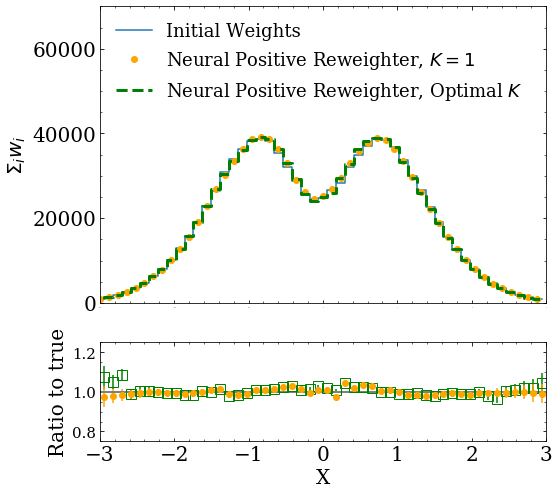

In [24]:
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1]) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#_,bins,_=plt.hist(X_val[Y_val==0],bins=np.linspace(-3,3,51),alpha=0.5,label="Unweighted")
myn2,bmjj=np.histogram(X_val[Y_val==1],weights=W_val[Y_val==1],bins=np.linspace(-3,3,51)) #,alpha=0.5,label="Weighted")
myn3,_=np.histogram(X_val[Y_val==0],weights=myw[Y_val==0][:,0],bins=np.linspace(-3,3,51)) #,label=r"Neural Positive Reweighter, $K=1$",histtype="step",color="orange",linewidth=5)
myn4,_=np.histogram(newxvals,weights=neweights,bins=np.linspace(-3,3,51)) #,label=r"Neural Positive Reweighter, Optimal $K$",histtype="step",color="green",ls=":",linewidth=5)

plt.step(0.5*(bmjj[1:]+bmjj[:-1]),myn2,label=r"Initial Weights")
plt.plot(0.5*(bmjj[1:]+bmjj[:-1])-0.5*6/51,myn3,label=r"Neural Positive Reweighter, $K=1$",ls="none",marker="o",color="orange")
plt.step(0.5*(bmjj[1:]+bmjj[:-1]),myn4,label=r"Neural Positive Reweighter, Optimal $K$",ls="--",color="green",linewidth=3)

plt.legend(frameon=False,fontsize=18,loc="upper left")
plt.xlim([-3,3])
plt.ylim([0,70000])
plt.ylabel(r"$\Sigma_i w_i$",fontsize=20)
plt.xlabel("",fontsize=20)
plt.xticks(fontsize=0)
plt.locator_params(axis='y', nbins=6)

ax1 = plt.subplot(gs[1])
ax1.yaxis.set_ticks_position('both')
ax1.xaxis.set_ticks_position('both')
ax1.tick_params(direction="in",which="both")
ax1.minorticks_on()
plt.xlim([-3,3])
plt.locator_params(axis='x', nbins=6)
plt.xlabel(r"X",fontsize=20)
plt.ylabel("Ratio to true",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=15)
plt.axhline(y=1,linewidth=2, color='gray')   
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn3/myn2,yerr=(W2_new[:,0][:-1]+myn2)**0.5/myn2,color='green',fmt='s',fillstyle="none",markersize=10)
plt.errorbar(0.5*(bmjj[1:]+bmjj[:-1]),myn4/myn2,yerr=(W2_sampled[:-1]+myn2)**0.5/myn2,color='orange',fmt="o")
plt.ylim(0.75,1.25)
#plt.xlim(-0.5,9.5)

plt.savefig("gauss_withK.pdf",bbox_inches='tight')

In [25]:
print(len(X_val[Y_val==1]))
print(len(X_val[Y_val==0]))
print(len(newxvals))
print(len(newxvals)/len(X_val[Y_val==0]))

1999719
2000281
651835
0.3258717150240391


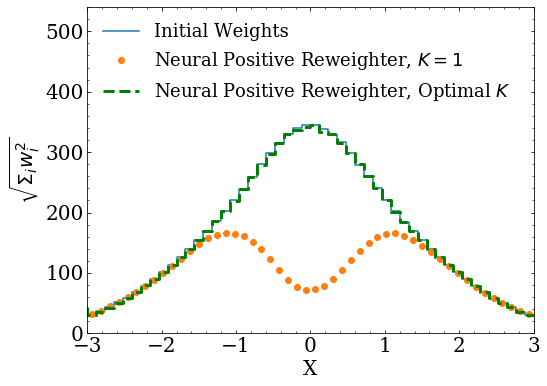

In [26]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

bins=np.linspace(-3,3,51)

plt.step(bins,np.array(W2_original)**0.5,label="Initial Weights")
plt.step(bins-0.5*6/51,np.array(W2_new)**0.5,label=r"Neural Positive Reweighter, $K=1$",marker='o',ls="none")
plt.step(bins,np.array(W2_sampled)**0.5,label=r"Neural Positive Reweighter, Optimal $K$",ls="--",linewidth=3,color="green")
plt.legend(frameon=False,fontsize=18,loc="upper left")

plt.ylim([0,180*3])
plt.xlim([-3,3])
plt.ylabel(r"$\sqrt{\Sigma_i w_i^2}$",fontsize=20)
plt.xlabel("X",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.savefig("gauss_sumw2.pdf",bbox_inches='tight')

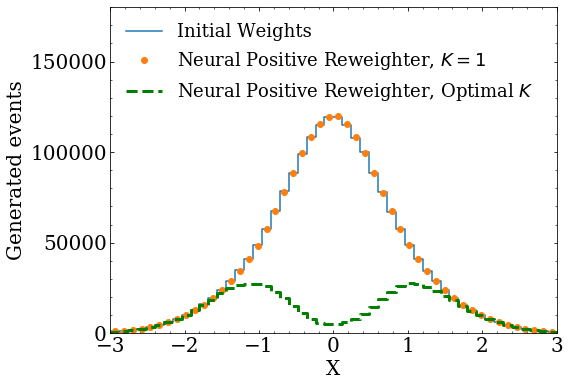

In [27]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.step(bins,L2_original,label="Initial Weights")
plt.step(bins-0.5*6/51,L2_new,label=r"Neural Positive Reweighter, $K=1$",marker='o',ls="none")
plt.step(bins,L2_sampled,label=r"Neural Positive Reweighter, Optimal $K$",ls="--",linewidth=3,color="green")
plt.legend(frameon=False,fontsize=18,loc="upper left")

plt.ylim([0,180000])
plt.ylabel("Generated events",fontsize=20)
plt.xlabel("X",fontsize=20)
plt.locator_params(axis='y', nbins=6)
plt.xlim([-3,3])
plt.savefig("gauss_N.pdf",bbox_inches='tight')